## Part 3

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import datetime
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


seed = 309
random.seed(seed)
np.random.seed(seed)

In [2]:
"""
A function used to compute for the loss

"""  

import numpy as np


def compute_loss(y, x, theta, metric_type):
    """
    Compute the loss of given data with respect to the ground truth
      y            ground truth
      x            input data (feature matrix)
      theta        model parameters (w and b)
      metric_type  metric type seletor, e.g., "MSE" indicates the Mean Squared Error.
    """
    if metric_type.upper() == "MSE":
        return np.mean(np.power(x.dot(theta) - y, 2))
    elif metric_type.upper() == "RMSE":
        return np.sqrt(np.mean(np.power(x.dot(theta) - y, 2)))
    elif metric_type.upper() == "R2":
        return - (1 - np.mean(np.power(x.dot(theta) - y, 2)) / np.mean(np.power(y - np.mean(y), 2)))
    elif metric_type.upper() == "MAE":
        return np.mean(np.abs(y - x.dot(theta)))

In [3]:
from utilities.losses import compute_loss


def gradient_descent(y, x, theta, max_iters, alpha, metric_type):
    """
    Batch Gradient Descent
    :param y:               ground truth
    :param x:               input data (feature matrix)
    :param theta:           model parameters (w and b)
    :param max_iters:       max iterations
    :param alpha:           step size
    :param metric_type:     metric type
    :return: thetas         all tracked updated model parameters
             losses         all tracked losses during the learning course
    """
    losses = []
    thetas = []
    num_of_samples = len(x)
    for i in range(max_iters):
        # This is for MSE loss only
        gradient = -2 * x.T.dot(y - x.dot(theta)) / num_of_samples
        theta = theta - alpha * gradient
        loss = compute_loss(y, x, theta, metric_type)

        # Track losses and thetas
        thetas.append(theta)
        losses.append(loss)

        print("BGD({bi}/{ti}): loss={l}, w={w}, b={b}".format(
            bi = i, ti = max_iters - 1, l = loss, w = theta[0], b = theta[1]))
    return thetas, losses


def mini_batch_gradient_descent(y, x, theta, max_iters, alpha, metric_type, mini_batch_size):
    """
    Mini Batch Gradient Descent
    :param y:               ground truth
    :param x:               input data (feature matrix)
    :param theta:           model parameters (w and b)
    :param max_iters:       max iterations
    :param alpha:           step size
    :param metric_type:     metric type
    :param mini_batch_size: mini batch size
    :return: thetas         all tracked updated model parameters
             losses         all tracked losses during the learning course
    """
    losses = []
    thetas = []
    # Please refer to the function "gradient_descent" to implement the mini-batch gradient descent here
    num_of_samples = len(x)
    for i in range(max_iters):
        # This is for MSE loss only
        gradient = -2 * x.T.dot(y - x.dot(theta)) / num_of_samples
        theta = theta - alpha * gradient
        loss = compute_loss(y, x, theta, metric_type)

        # Track losses and thetas
        thetas.append(theta)
        losses.append(loss)

        print("BGD({bi}/{ti}): loss={l}, w={w}, b={b}".format(
            bi = i, ti = max_iters - 1, l = loss, w = theta[0], b = theta[1]))
    return thetas, losses


def pso(y, x, theta, max_iters, pop_size, metric_type):
    """
    Particle Swarm Optimization
    :param y:               train labels
    :param x:               train data
    :param theta:           model parameters
    :param max_iters:       max iterations
    :param pop_size:        population size
    :param metric_type:     metric type (MSE, RMSE, R2, MAE)
    :return: best_thetas    all tracked best model parameters for each generation
             losses         all tracked losses of the best model in each generation
    """
    # Init settings
    w = 0.729844  # Inertia weight to prevent velocities becoming too large
    c_p = 1.496180  # Scaling co-efficient on the social component
    c_g = 1.496180  # Scaling co-efficient on the cognitive component

    terminate = False
    g_best = theta

    lower_bound = -100
    upper_bound = 100

    velocity = []
    thetas = []
    p_best = []

    # Track results
    best_thetas = []
    losses = []

    # initialization
    for i in range(pop_size):
        theta = np.random.uniform(lower_bound, upper_bound, len(theta))
        thetas.append(theta)
        p_best.append(theta)
        if compute_loss(y, x, theta, metric_type) < compute_loss(y, x, g_best, metric_type):
            g_best = theta.copy()
        velocity.append(
            np.random.uniform(-np.abs(upper_bound - lower_bound), np.abs(upper_bound - lower_bound), len(theta)))

    # Evolution
    count = 0
    while not terminate:
        for i in range(pop_size):
            rand_p = np.random.uniform(0, 1, size = len(theta))
            rand_g = np.random.uniform(0, 1, size = len(theta))
            velocity[i] = w * velocity[i] + c_p * rand_p * (p_best[i] - thetas[i]) + c_g * rand_g * (g_best - thetas[i])
            thetas[i] = thetas[i] + velocity[i]
            if compute_loss(y, x, thetas[i], metric_type) < compute_loss(y, x, p_best[i], metric_type):
                p_best[i] = thetas[i]
                if compute_loss(y, x, p_best[i], metric_type) < compute_loss(y, x, g_best, metric_type):
                    g_best = p_best[i]
        best_thetas.append(g_best)
        current_loss = compute_loss(y, x, g_best, metric_type)
        losses.append(current_loss)

        print("PSO({bi}/{ti}): loss={l}, w={w}, b={b}".format(
            bi = count, ti = max_iters - 1, l = current_loss, w = g_best[0], b = g_best[1]))
        count += 1
        if count >= max_iters:
            terminate = True
    return best_thetas, losses



In [7]:
"""
This is an example to perform simple linear regression algorithm on the dataset (weight and height),
where x = weight and y = height.
"""
import datetime
import random

from utilities.losses import compute_loss
from utilities.optimizers import gradient_descent, pso, mini_batch_gradient_descent
from sklearn.model_selection import train_test_split

# General settings
from utilities.visualization import visualize_train, visualize_test

seed = 309
# Freeze the random seed
random.seed(seed)
np.random.seed(seed)
train_test_split_test_size = 0.3

# Training settings
alpha = 0.1  # step size
max_iters = 50  # max iterations


def load_data():
    """
    Load Data from CSV
    :return: df    a panda data frame
    """
    df = pd.read_csv("/Users/keirynhart/Documents/Uni/Comp 309/Assignment 4/Part2.csv")
    return df


def data_preprocess(data):
    """
    Data preprocess:
        1. Split the entire dataset into train and test
        2. Split outputs and inputs
        3. Standardize train and test
        4. Add intercept dummy for computation convenience
    :param data: the given dataset (format: panda DataFrame)
    :return: train_data       train data contains only inputs
             train_labels     train data contains only labels
             test_data        test data contains only inputs
             test_labels      test data contains only labels
             train_data_full       train data (full) contains both inputs and labels
             test_data_full       test data (full) contains both inputs and labels
    """
    # Split the data into train and test
    train_data, test_data = train_test_split(data, test_size = train_test_split_test_size)

    # Pre-process data (both train and test)
    train_data_full = train_data.copy()
    train_data = train_data.drop(["Height"], axis = 1)
    train_labels = train_data_full["Height"]

    test_data_full = test_data.copy()
    test_data = test_data.drop(["Height"], axis = 1)
    test_labels = test_data_full["Height"]

    # Standardize the inputs
    train_mean = train_data.mean()
    train_std = train_data.std()
    train_data = (train_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std

    # Tricks: add dummy intercept to both train and test
    train_data['intercept_dummy'] = pd.Series(1.0, index = train_data.index)
    test_data['intercept_dummy'] = pd.Series(1.0, index = test_data.index)
    return train_data, train_labels, test_data, test_labels, train_data_full, test_data_full


def learn(y, x, theta, max_iters, alpha, optimizer_type = "BGD", metric_type = "MSE"):
    """
    Learn to estimate the regression parameters (i.e., w and b)
    :param y:                   train labels
    :param x:                   train data
    :param theta:               model parameter
    :param max_iters:           max training iterations
    :param alpha:               step size
    :param optimizer_type:      optimizer type (default: Batch Gradient Descient): GD, SGD, MiniBGD or PSO
    :param metric_type:         metric type (MSE, RMSE, R2, MAE). NOTE: MAE can't be optimized by GD methods.
    :return: thetas              all updated model parameters tracked during the learning course
             losses             all losses tracked during the learning course
    """
    thetas = None
    losses = None
    if optimizer_type == "BGD":
        thetas, losses = gradient_descent(y, x, theta, max_iters, alpha, metric_type)
    elif optimizer_type == "MiniBGD":
        thetas, losses = mini_batch_gradient_descent(y, x, theta, max_iters, alpha, metric_type, mini_batch_size = 10)
    elif optimizer_type == "PSO":
        thetas, losses = pso(y, x, theta, max_iters, 100, metric_type)
    else:
        raise ValueError(
            "[ERROR] The optimizer '{ot}' is not defined, please double check and re-run your program.".format(
                ot = optimizer_type))
    
    start_time = datetime.datetime.now()  # Track learning starting time
    thetas, losses = learn(train_labels.values, train_data.values, theta, max_iters, alpha, optimizer_type, metric_type)

    end_time = datetime.datetime.now()  # Track learning ending time
    exection_time = (end_time - start_time).total_seconds()  # Track execution time

    # Step 4: Results presentation
    print("Learn: execution time={t:.3f} seconds".format(t = exection_time))

    # Build baseline model
    print("R2:", -compute_loss(test_labels.values, test_data.values, thetas[-1], "R2"))  # R2 should be maximize
    print("MSE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "MSE"))
    print("RMSE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "RMSE"))
    print("MAE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "MAE"))
    
    return thetas, losses


if __name__ == '__main__':
    # Settings
    metric_type = "MSE"  # MSE, RMSE, MAE, R2
    optimizer_type = "BGD"  # PSO, BGD

    # Step 1: Load Data
    data = load_data()

    # Step 2: Preprocess the data
    train_data, train_labels, test_data, test_labels, train_data_full, test_data_full = data_preprocess(data)

    # Step 3: Learning Start
    theta = np.array([0.0, 0.0])  # Initialize model parameter

    start_time = datetime.datetime.now()  # Track learning starting time
    #thetas, losses = learn(train_labels.values, train_data.values, theta, max_iters, alpha, optimizer_type, metric_type)

    end_time = datetime.datetime.now()  # Track learning ending time
    exection_time = (end_time - start_time).total_seconds()  # Track execution time

    # Step 4: Results presentation
    print("Learn: execution time={t:.3f} seconds".format(t = exection_time))

    # Build baseline model
    #print("R2:", -compute_loss(test_labels.values, test_data.values, thetas[-1], "R2"))  # R2 should be maximize
    #print("MSE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "MSE"))
    #print("RMSE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "RMSE"))
    #print("MAE:", compute_loss(test_labels.values, test_data.values, thetas[-1], "MAE"))



    

Learn: execution time=0.000 seconds


In [8]:
"""
Visualization functions
"""

import matplotlib.pyplot as plt
import numpy as np

# Visualize the training course
from utilities.losses import compute_loss


def compute_z_loss(y, x, thetas):
    """
    Compute z-axis values
    :param y:            train labels
    :param x:            train data
    :param thetas:       model parameters
    :return: z_losses    value (loss) for z-axis
    """
    thetas = np.array(thetas)
    w = thetas[:, 0].reshape(thetas[:, 0].shape[0], )
    b = thetas[:, 1].reshape(thetas[:, 1].shape[0], )
    z_losses = np.zeros((len(w), len(b)))
    for ind_row, row in enumerate(w):
        for ind_col, col in enumerate(b):
            theta = np.array([row, col])
            z_losses[ind_row, ind_col] = compute_loss(y, x, theta, "MSE")
    return z_losses


def predict(x, thetas):
    """
    Predict function
    :param x:               test data
    :param thetas:          trained model parameters
    :return:                prediced labels
    """
    return x.dot(thetas)


def visualize_train(train_data_full, train_labels, train_data, thetas, losses, niter):
    """
    Visualize Function for Training Results
    :param train_data_full:   the train data set (full) with labels and data
    :param thetas:            model parameters
    :param losses:            all tracked losses
    :param niter:             completed training iterations
    :return: fig1              the figure for line fitting on training data
             fig2              learning curve in terms of error
             fig3              gradient variation visualization
    """
    fig1, ax1 = plt.subplots()
    ax1.scatter(train_data_full["Weight"], train_data_full["Height"], color = 'blue')

    # De-standarize
    train_mean = train_data_full["Weight"].mean()
    train_std = train_data_full["Weight"].std()
    train_data_for_plot = train_mean + train_data["Weight"] * train_std

    ax1.plot(train_data_for_plot, predict(train_data, thetas[niter - 1]), color = 'red', linewidth = 2)
    ax1.set_xlabel("Height")
    ax1.set_ylabel("Weight")

    fig2, ax2 = plt.subplots()
    ax2.plot(range(len(losses)), losses, color = 'blue', linewidth = 2)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("MSE")

    fig3, ax3 = plt.subplots()
    np_gradient_ws = np.array(thetas)

    w = np.linspace(min(np_gradient_ws[:, 0]), max(np_gradient_ws[:, 0]), len(np_gradient_ws[:, 0]))
    b = np.linspace(min(np_gradient_ws[:, 1]), max(np_gradient_ws[:, 1]), len(np_gradient_ws[:, 1]))
    x, y = np.meshgrid(w, b)
    z = compute_z_loss(train_labels, train_data, np.stack((w,b)).T)
    cp = ax3.contourf(x, y, z, cmap = plt.cm.jet)
    fig3.colorbar(cp, ax = ax3)
    ax3.plot(3.54794951, 66.63949115837143, color = 'red', marker = '*', markersize = 20)
    if niter > 0:
        thetas_to_plot = np_gradient_ws[:niter]
    ax3.plot(thetas_to_plot[:, 0], thetas_to_plot[:, 1], marker = 'o', color = 'w', markersize = 10)
    ax3.set_xlabel(r'$w$')
    ax3.set_ylabel(r'$b$')
    return fig1, fig2, fig3


def visualize_test(test_data_full, test_data, thetas):
    """
    Visualize Test for Testing Results
    :param test_data_full:          the test data set (full) with labels and data
    :param thetas:                  model parameters
    :return: fig
    """
    fig, ax = plt.subplots()
    ax.scatter(test_data_full["Weight"], test_data_full["Height"], color='blue')
    ax.plot(test_data_full["Weight"], predict(test_data, thetas[-1]), color='red', linewidth=2)
    return fig

In [9]:
theta = np.array([0.0,0.0])

In [10]:
df = load_data()

In [11]:
df = data_preprocess(df)

In [12]:
#BGD_MSE = learn(train_labels, train_data, theta, 50, 0.1, "BGD", "MSE")
start_time = datetime.datetime.now()
thetas1, losses1 = gradient_descent(train_labels, train_data, theta, 50, 0.1, "MSE")

end_time = datetime.datetime.now()
exection_time = (end_time - start_time).total_seconds()
print("Learn: execution time={t:.3f} seconds".format(t = exection_time))

print("R2:", -compute_loss(test_labels, test_data, thetas1[-1], "R2"))  # R2 should be maximize
print("MSE:", compute_loss(test_labels, test_data, thetas1[-1], "MSE"))
print("RMSE:", compute_loss(test_labels, test_data, thetas1[-1], "RMSE"))
print("MAE:", compute_loss(test_labels, test_data, thetas1[-1], "MAE"))


#visualize_train(train_data_full, train_labels, train_data, thetas, losses, 50)

BGD(0/49): loss=2852.039134851559, w=0.7075625032674936, b=13.327898231674286
BGD(1/49): loss=1825.9850450301685, w=1.2740168273119257, b=23.990216817013714
BGD(2/49): loss=1169.3077854571823, w=1.7275039747326382, b=32.52007168528526
BGD(3/49): loss=749.0326459781148, w=2.090552828182019, b=39.34395557990249
BGD(4/49): loss=480.055471417244, w=2.3811993674292085, b=44.80306269559628
BGD(5/49): loss=307.9093841173318, w=2.613882682563672, b=49.17034838815131
BGD(6/49): loss=197.73544243739008, w=2.800162296565605, b=52.66417694219533
BGD(7/49): loss=127.22383403736698, w=2.949292433260866, b=55.459239785430555
BGD(8/49): loss=82.09622153611429, w=3.0686817598380434, b=57.69529006001873
BGD(9/49): loss=53.21443216767159, w=3.164261443572115, b=59.48413027968927
BGD(10/49): loss=34.73001174923218, w=3.2407798075215055, b=60.9152024554257
BGD(11/49): loss=22.89993447014434, w=3.3020382234604178, b=62.060060196014845
BGD(12/49): loss=15.328654112210042, w=3.3510799610206554, b=62.975946388

In [14]:
pred = predict(test_data, thetas1[-1])

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 2 Axes>)

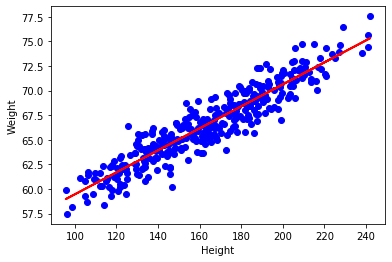

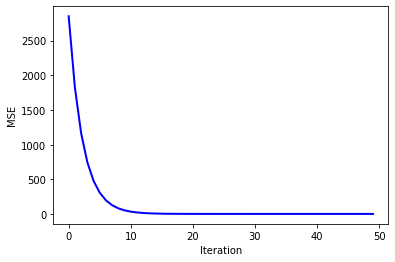

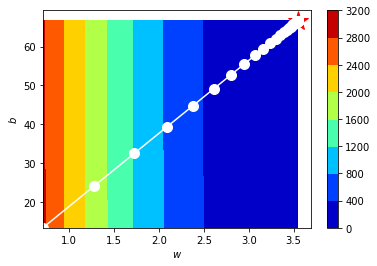

In [15]:
visualize_train(train_data_full, train_labels, train_data, thetas1, losses1, 50)

In [16]:
start_time = datetime.datetime.now()

thetas2, losses2 = mini_batch_gradient_descent(train_labels, train_data, theta, 50, 0.1, "MSE", 10)

end_time = datetime.datetime.now()
exection_time = (end_time - start_time).total_seconds()
print("Learn: execution time={t:.3f} seconds".format(t = exection_time))

#(train_labels, train_data, theta, 50, 0.1, "MSE")

Learn: execution time=0.000 seconds
